In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder, teamdashboardbygeneralsplits, playercareerstats
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.static import teams, players
import seaborn as sns
import re

In [64]:
team_stats = pd.read_csv('data/team_stats_cleaned.csv')
team_stats.head(10)
team_stats.columns

Index(['group_set', 'group_value', 'season_year', 'gp', 'w', 'l', 'w_pct',
       'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus', 'gp_rank', 'w_rank', 'l_rank',
       'w_pct_rank', 'min_rank', 'fgm_rank', 'fga_rank', 'fg_pct_rank',
       'fg3m_rank', 'fg3a_rank', 'fg3_pct_rank', 'ftm_rank', 'fta_rank',
       'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'reb_rank', 'ast_rank',
       'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank',
       'pts_rank', 'plus_minus_rank', 'team_name'],
      dtype='object')

In [65]:
columns_to_keep = ['season_year', 'fgm', 'fga','fg3_pct', 'ftm', 'fta','ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'team_name']
team_stats = team_stats[columns_to_keep]
team_stats['fg%'] = team_stats['fgm']/team_stats['fga']
team_stats.head(10)

,season_year,fgm,fga,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,tov,stl,blk,team_name,fg%
0,2024-25,1626,3498,0.354,707,901,0.785,456,1259,1715,1137,609.0,391,203,Atlanta Hawks,0.464837
1,2024-25,1548,3358,0.366,615,776,0.793,406,1257,1663,945,440.0,285,208,Boston Celtics,0.460989
2,2024-25,1673,3314,0.405,598,772,0.775,363,1252,1615,1087,481.0,324,171,Cleveland Cavaliers,0.504828
3,2024-25,1507,3422,0.336,611,797,0.767,476,1145,1621,938,569.0,364,206,New Orleans Pelicans,0.440386
4,2024-25,1598,3411,0.372,554,696,0.796,345,1321,1666,1084,560.0,280,173,Chicago Bulls,0.468484
5,2024-25,1613,3359,0.375,692,892,0.776,426,1290,1716,954,545.0,308,224,Dallas Mavericks,0.480202
6,2024-25,1623,3256,0.382,661,868,0.762,392,1234,1626,1130,508.0,313,169,Denver Nuggets,0.498464
7,2024-25,1523,3393,0.365,526,741,0.710,471,1252,1723,1063,536.0,329,202,Golden State Warriors,0.448865
8,2024-25,1542,3474,0.329,658,864,0.762,535,1270,1805,813,495.0,322,194,Houston Rockets,0.443869
9,2024-25,1471,3173,0.363,626,803,0.780,397,1233,1630,895,610.0,359,166,Los Angeles Clippers,0.463599


In [66]:
team_stats = team_stats.sort_values('team_name')
team_stats.head(10)

,season_year,fgm,fga,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,tov,stl,blk,team_name,fg%
0,2024-25,1626,3498,0.354,707,901,0.785,456,1259,1715,1137,609.0,391,203,Atlanta Hawks,0.464837
1,2024-25,1548,3358,0.366,615,776,0.793,406,1257,1663,945,440.0,285,208,Boston Celtics,0.460989
14,2024-25,1405,3135,0.366,628,776,0.809,344,1121,1465,931,576.0,271,135,Brooklyn Nets,0.448166
29,2024-25,1337,3148,0.341,538,697,0.772,454,1164,1618,819,561.0,281,173,Charlotte Hornets,0.424714
4,2024-25,1598,3411,0.372,554,696,0.796,345,1321,1666,1084,560.0,280,173,Chicago Bulls,0.468484
2,2024-25,1673,3314,0.405,598,772,0.775,363,1252,1615,1087,481.0,324,171,Cleveland Cavaliers,0.504828
5,2024-25,1613,3359,0.375,692,892,0.776,426,1290,1716,954,545.0,308,224,Dallas Mavericks,0.480202
6,2024-25,1623,3256,0.382,661,868,0.762,392,1234,1626,1130,508.0,313,169,Denver Nuggets,0.498464
28,2024-25,1578,3380,0.362,579,756,0.766,423,1276,1699,977,602.0,279,195,Detroit Pistons,0.466864
7,2024-25,1523,3393,0.365,526,741,0.710,471,1252,1723,1063,536.0,329,202,Golden State Warriors,0.448865


In [69]:
nba_teams = [
    'ATL', 'BOS', 'BRO', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 
    'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 
    'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]
nba_teams.sort()
nba_teams

team_stats['Team'] = nba_teams
team_stats = team_stats.drop(columns = ['team_name'])
team_stats.head(10)


,season_year,fgm,fga,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,tov,stl,blk,fg%,Team
0,2024-25,1626,3498,0.354,707,901,0.785,456,1259,1715,1137,609.0,391,203,0.464837,ATL
1,2024-25,1548,3358,0.366,615,776,0.793,406,1257,1663,945,440.0,285,208,0.460989,BOS
14,2024-25,1405,3135,0.366,628,776,0.809,344,1121,1465,931,576.0,271,135,0.448166,BRO
29,2024-25,1337,3148,0.341,538,697,0.772,454,1164,1618,819,561.0,281,173,0.424714,CHA
4,2024-25,1598,3411,0.372,554,696,0.796,345,1321,1666,1084,560.0,280,173,0.468484,CHI
2,2024-25,1673,3314,0.405,598,772,0.775,363,1252,1615,1087,481.0,324,171,0.504828,CLE
5,2024-25,1613,3359,0.375,692,892,0.776,426,1290,1716,954,545.0,308,224,0.480202,DAL
6,2024-25,1623,3256,0.382,661,868,0.762,392,1234,1626,1130,508.0,313,169,0.498464,DEN
28,2024-25,1578,3380,0.362,579,756,0.766,423,1276,1699,977,602.0,279,195,0.466864,DET
7,2024-25,1523,3393,0.365,526,741,0.710,471,1252,1723,1063,536.0,329,202,0.448865,GSW


In [71]:
def clean_and_extract_team_id(team_name):
    # Remove seed numbers and parentheses
    cleaned_name = re.sub(r'\s\(\d+\)', '', team_name)
    # Extract first three letters and convert to uppercase
    team_id = cleaned_name[:3].upper()
    return team_id

relabeled_dict = {
    "Team": "Team1",
    "Team.1": "Team2",
    "W": "Team1wins",
    "W.1": "Team2wins"
}
playoff_results = pd.read_csv('data/playoff_results.csv') 
playoff_results = playoff_results.rename(columns=relabeled_dict)
playoff_results['Team1'] = playoff_results['Team1'].apply(clean_and_extract_team_id)
playoff_results['Team2'] = playoff_results['Team2'].apply(clean_and_extract_team_id) 
playoff_results.replace('CHA', 'CHO', inplace=True)


# Reshape the DataFrame so that both Team1 and Team2 are treated as teams with their respective wins
team1_wins = playoff_results[['Yr', 'Team1', 'Team1wins']].rename(columns={'Team1': 'Team', 'Team1wins': 'wins'})
team2_wins = playoff_results[['Yr', 'Team2', 'Team2wins']].rename(columns={'Team2': 'Team', 'Team2wins': 'wins'})

# Combine both team1 and team2 data into one DataFrame
combined_wins = pd.concat([team1_wins, team2_wins])

# Group by Year and Team, and sum the wins for each team
team_totals = combined_wins.groupby(['Yr', 'Team'], as_index=False)['wins'].sum()


team_totals_2024 = team_totals[team_totals['Yr'] == 2024]
print(team_totals_2024)

       Yr Team  wins
125  2024  BOS    16
126  2024  CLE     5
127  2024  DAL    13
128  2024  DEN     7
129  2024  IND     8
130  2024  LOS     3
131  2024  MIA     1
132  2024  MIL     2
133  2024  MIN     9
134  2024  NEW     7
135  2024  OKL     6
136  2024  ORL     3
137  2024  PHI     2
138  2024  PHO     0


In [81]:
# Ensure both 'Yr' columns are strings
team_stats['Yr'] = team_stats['Yr'].astype(str)
team_totals_2024['Yr'] = team_totals_2024['Yr'].astype(str)




# Merge the DataFrames
merged_data = pd.merge(team_stats, team_totals_2024, on=['Yr', 'Team'], how='left')

merged_data = merged_data[merged_data['wins'].notna()]
merged_data.head(10)


/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_82830/3855052676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_totals_2024['Yr'] = team_totals_2024['Yr'].astype(str)


,Yr,fgm,fga,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,tov,stl,blk,fg%,Team,wins
1,2024,1548,3358,0.366,615,776,0.793,406,1257,1663,945,440.0,285,208,0.460989,BOS,16.0
5,2024,1673,3314,0.405,598,772,0.775,363,1252,1615,1087,481.0,324,171,0.504828,CLE,5.0
6,2024,1613,3359,0.375,692,892,0.776,426,1290,1716,954,545.0,308,224,0.480202,DAL,13.0
7,2024,1623,3256,0.382,661,868,0.762,392,1234,1626,1130,508.0,313,169,0.498464,DEN,7.0
11,2024,1638,3347,0.374,632,810,0.780,340,1234,1574,1074,528.0,307,192,0.489393,IND,8.0
15,2024,1421,3125,0.366,646,827,0.781,345,1220,1565,937,487.0,320,136,0.454720,MIA,1.0
16,2024,1447,3028,0.389,547,746,0.733,292,1243,1535,869,497.0,274,181,0.477873,MIL,2.0
17,2024,1445,3170,0.377,583,745,0.783,377,1236,1613,915,583.0,302,175,0.455836,MIN,9.0
21,2024,1477,3320,0.309,687,878,0.782,426,1198,1624,926,592.0,363,260,0.444880,ORL,3.0
22,2024,1335,2986,0.340,661,850,0.778,356,1043,1399,766,494.0,339,152,0.447086,PHI,2.0


In [85]:
# Rank each team for every single numeric category
ranked_data = merged_data.copy()
numeric_cols = ['fgm', 'fga', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 
                'ast', 'tov', 'stl', 'blk', 'fg%']  # Adjust list as needed

for col in numeric_cols:
    ranked_data[f'{col}_rank'] = ranked_data[col].rank(ascending=False)  # Higher is better

# Keep only relevant columns
ranked_data = ranked_data[['Yr', 'Team', 'wins'] + [f'{col}_rank' for col in numeric_cols]]

ranked_data.head()



,Yr,Team,wins,fgm_rank,fga_rank,fg3_pct_rank,ftm_rank,fta_rank,ft_pct_rank,oreb_rank,dreb_rank,reb_rank,ast_rank,tov_rank,stl_rank,blk_rank,fg%_rank
1,2024,BOS,16.0,5.0,2.0,7.5,7.0,7.0,1.0,3.0,2.0,2.0,5.0,10.0,9.0,3.0,6.0
5,2024,CLE,5.0,1.0,5.0,1.0,8.0,8.0,8.0,6.0,3.0,5.0,2.0,9.0,3.0,7.0,1.0
6,2024,DAL,13.0,4.0,1.0,5.0,1.0,1.0,7.0,1.5,1.0,1.0,4.0,3.0,6.0,2.0,4.0
7,2024,DEN,7.0,3.0,6.0,3.0,3.5,3.0,9.0,4.0,6.5,3.0,1.0,5.0,5.0,8.0,2.0
11,2024,IND,8.0,2.0,3.0,6.0,6.0,6.0,5.0,9.0,6.5,7.0,3.0,4.0,7.0,4.0,3.0


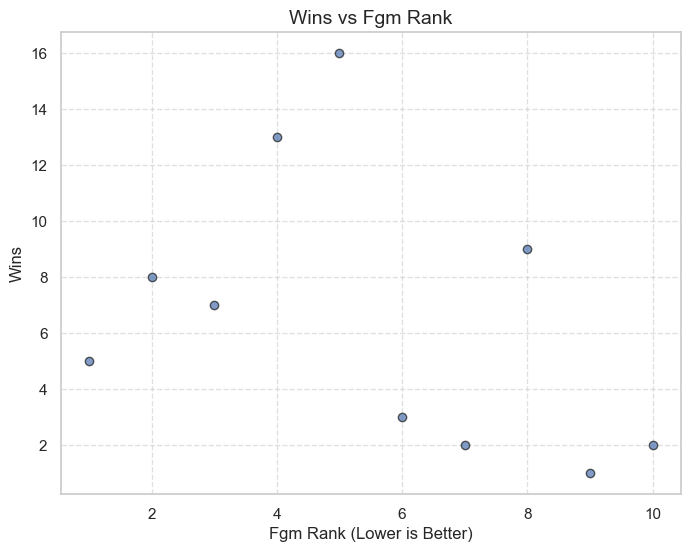

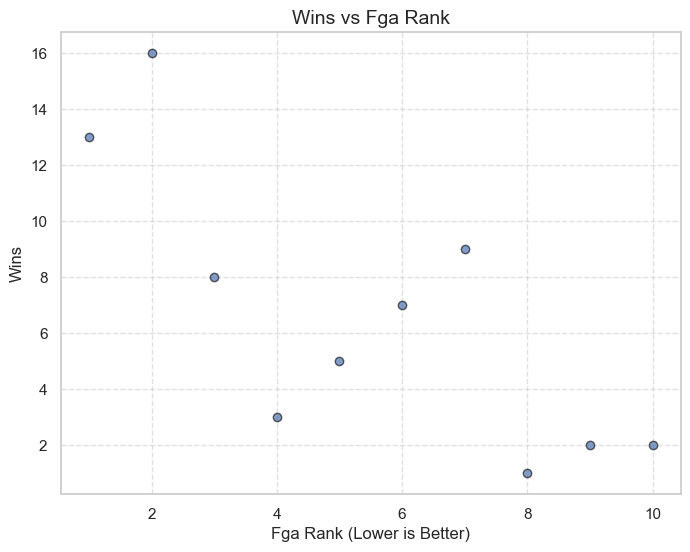

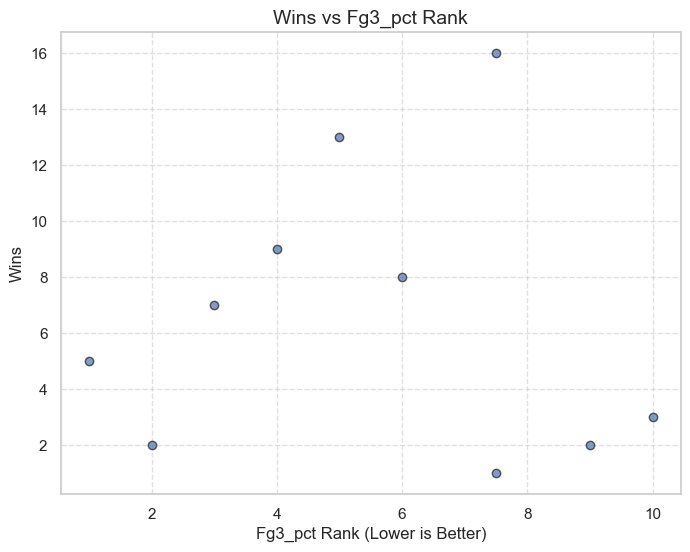

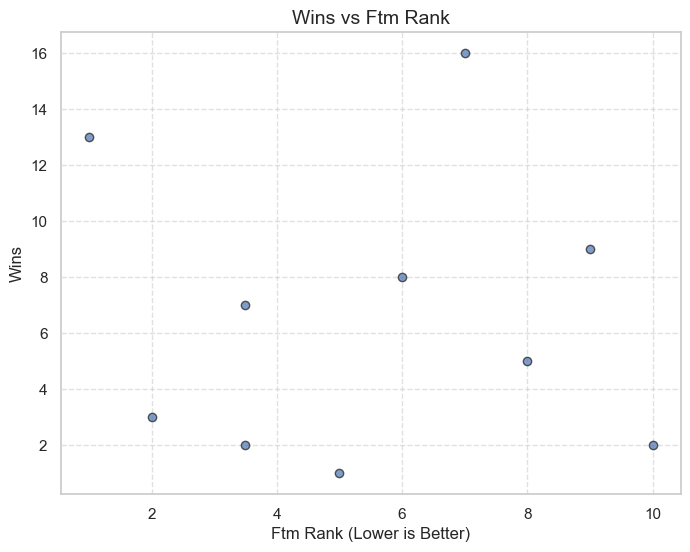

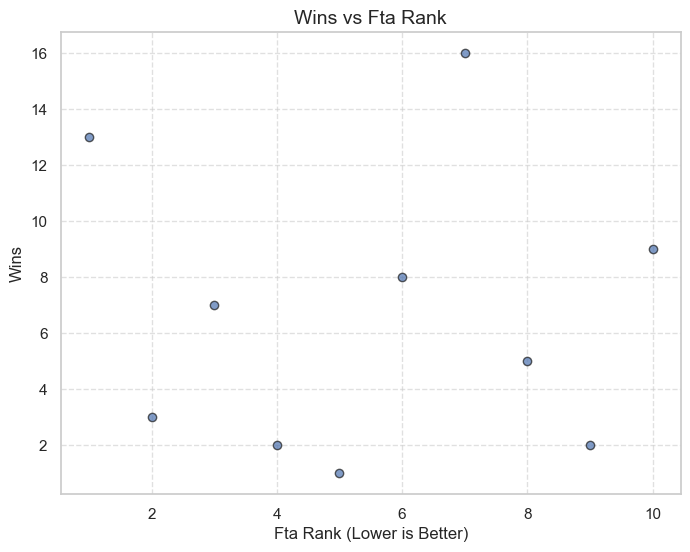

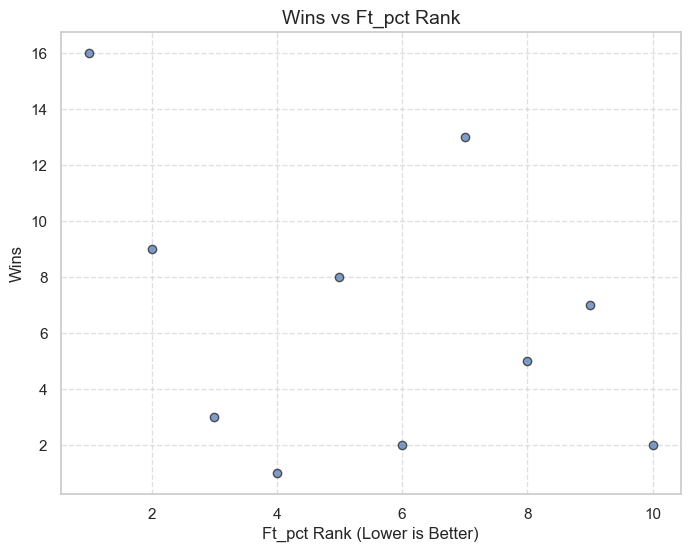

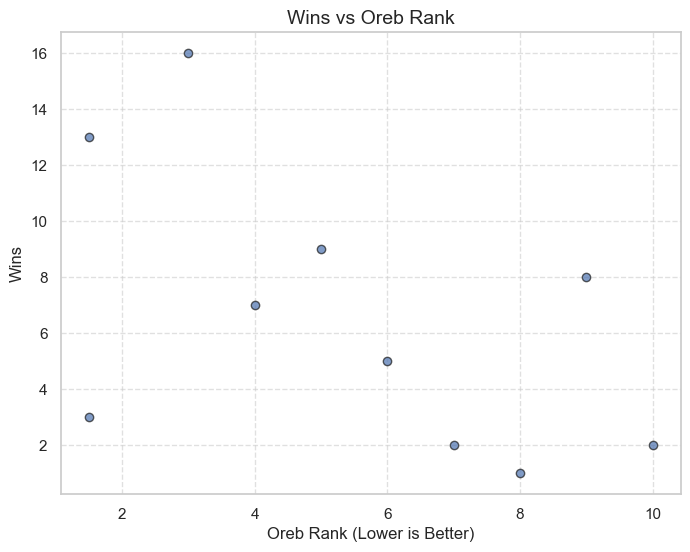

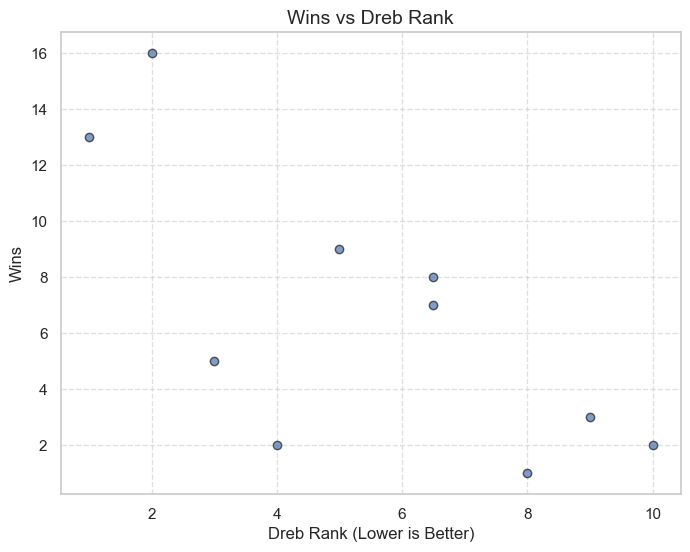

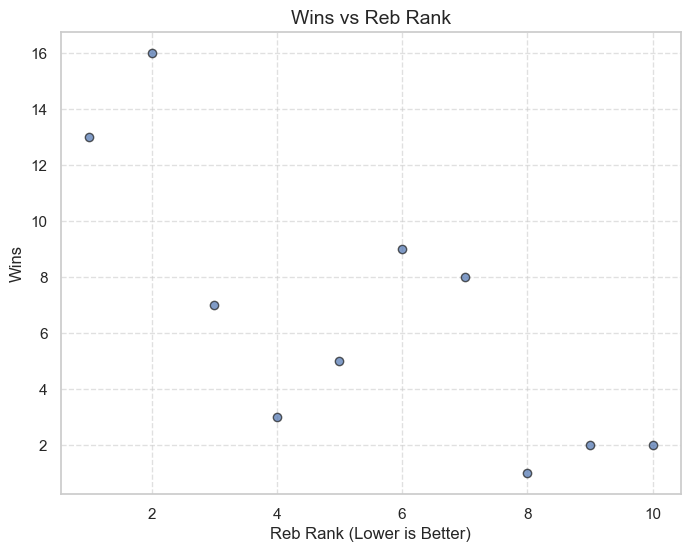

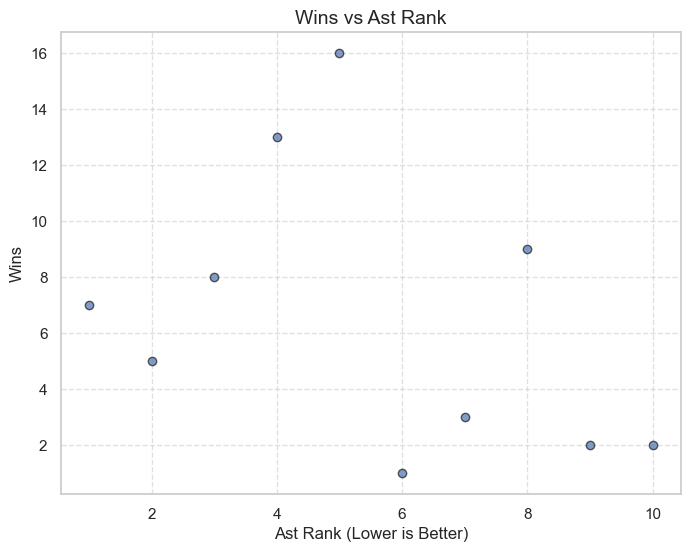

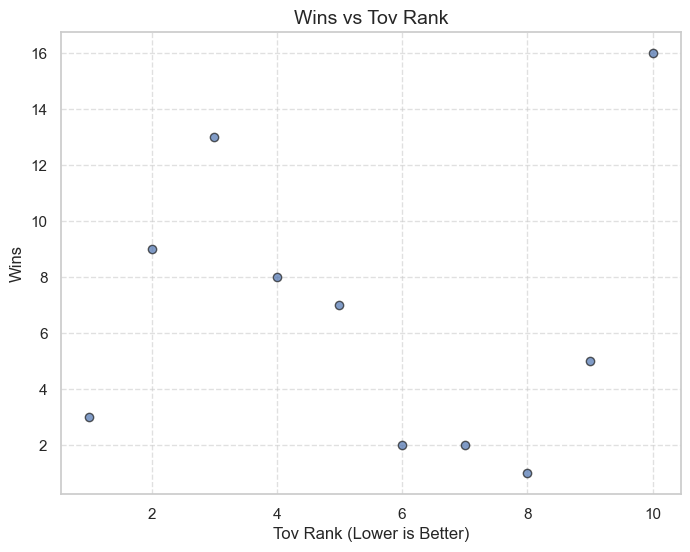

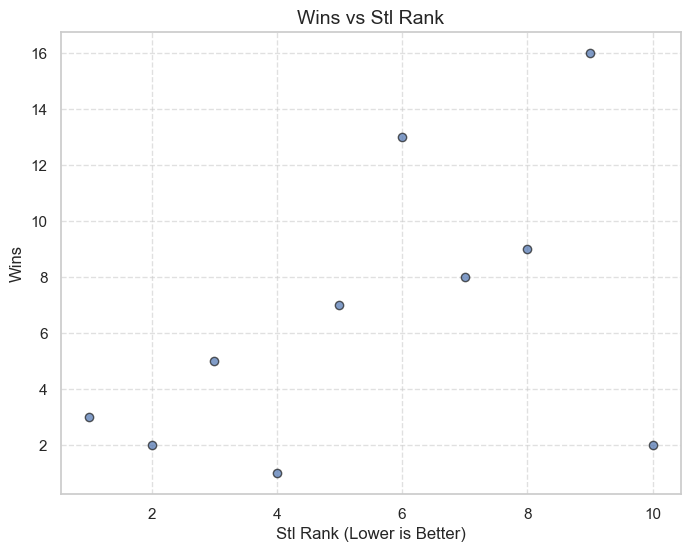

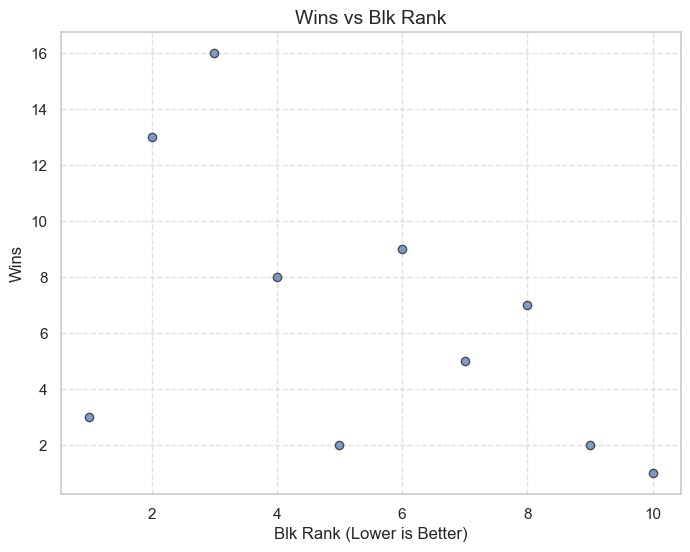

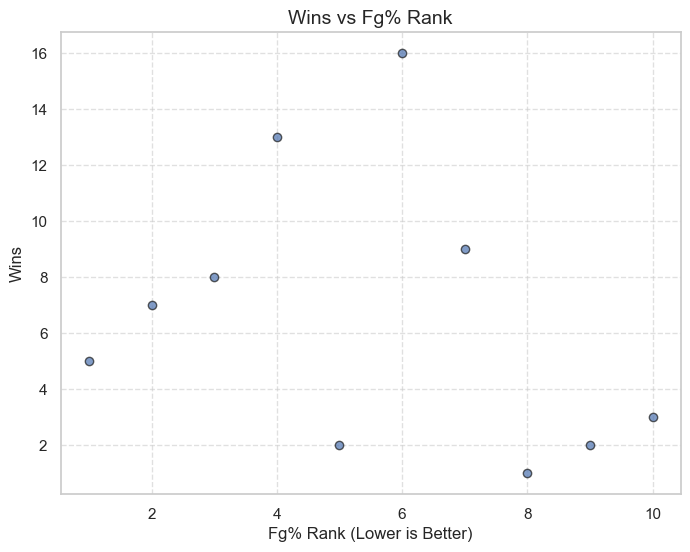

In [83]:
import matplotlib.pyplot as plt

# Create scatterplots
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    plt.scatter(ranked_data[f'{col}_rank'], ranked_data['wins'], alpha=0.7, edgecolor='k')
    plt.title(f'Wins vs {col.capitalize()} Rank', fontsize=14)
    plt.xlabel(f'{col.capitalize()} Rank (Lower is Better)', fontsize=12)
    plt.ylabel('Wins', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


In [93]:
correlation_results = []

# Loop through numeric_cols and calculate correlation
for col in numeric_cols:
    rank_col = f"{col}_rank"  # Generate the column name dynamically
    if rank_col in ranked_data.columns:  # Check if the column exists
        correlation = abs(ranked_data[rank_col].corr(ranked_data['wins']))
        correlation_results.append({'Metric': rank_col, 'Correlation with Playoff Wins': correlation})
    else:
        correlation_results.append({'Metric': rank_col, 'Correlation with Wins': 'N/A'})

# Convert the results into a DataFrame for display
correlation_table = pd.DataFrame(correlation_results)

# Display the table
correlation_table_sorted = correlation_table.sort_values('Correlation with Playoff Wins', ascending = False)
print(correlation_table_sorted)



          Metric  Correlation with Playoff Wins
1       fga_rank                       0.775605
8       reb_rank                       0.760971
7      dreb_rank                       0.715582
6      oreb_rank                       0.543108
12      blk_rank                       0.519509
11      stl_rank                       0.497558
0       fgm_rank                       0.409754
9       ast_rank                       0.387803
5    ft_pct_rank                       0.365851
13      fg%_rank                       0.314632
2   fg3_pct_rank                       0.062384
3       ftm_rank                       0.047705
10      tov_rank                       0.021951
4       fta_rank                       0.014634
